In [5]:
# -*- coding: utf-8 -*-

import os, json, re, random, sys
from os.path import join, dirname, basename, split, splitext
from collections import Counter, defaultdict, OrderedDict

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

sys.path.append('../tools')
import general as ge

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

%matplotlib inline

# 1. Read the original text.

The text is "Pride and Prejudice".

In [50]:
_, original_words = ge.read_file('../example texts/1813 PRIDE AND PREJUDICE.txt', use_zip=0, zf='none')
# original_words = orignal_words[:40000]
lenght_original_text = len(original_words)

# 2. For speed, shrink vocabulary.


## 2.1. Cooccurrence.

In [51]:
stops = stopwords.words('english')
words_0stop = [w for w in original_words if not w in stops]
words_0stop_stem = [porter.stem(w) for w in words_0stop]
c = Counter(words_0stop_stem)
threshold = 4
words_0stop_stem_threshold = [w for w, count in c.items() if count >= threshold]
vocab = words_0stop_stem_threshold
words_stem = [porter.stem(w) for w in original_words]
original_vocab = list(set(words_stem))

In [53]:
# Convert into numbers.
words_stem_numeric = np.array([original_vocab.index(w) for w in words_stem])
vocab_numeric = np.array([original_vocab.index(w) for w in vocab])

## 2.2. Word-doc

For word-doc, there's no need to transfer to number to speedup.

In [5]:
stops = stopwords.words('english')
words_0stop = [w for w in original_words if not w in stops]
words_0stop_stem = [porter.stem(w) for w in words_0stop]
c = Counter(words_0stop_stem)
threshold = 4
words_0stop_stem_threshold = [w for w, count in c.items() if count >= threshold]
final_vocab = words_0stop_stem_threshold
words_stem = [porter.stem(w) for w in original_words]

# 3. Building the semantic matrix.

We have two ways of building the semantic matrix.
1. From the words-docs matrix. The words-docs matrix is a matrix $M$, in which $m_{im}$ is the number of appearances of word $i$ in subtext $m$.
2. From the cooccurrence matrix. But consider a window of cooccurr.

## 3.1. Cooccurrence matrix.

For the cooccurrence matrix, a randomazation is done.

In [54]:
# Funtions.

def count_cooccurrrence(word, word1, window_length, words_numbers):
    indices_v = np.where(words_numbers == word)
    indices_v1 = np.where(words_numbers == word1)
    distances = np.zeros([np.size(indices_v), np.size(indices_v1)])
    for ind in np.arange(np.size(indices_v)):
        index_v = indices_v[0][ind] # indices_v is tuple
        distances[ind, :] = np.absolute(indices_v1 - index_v)
    threshold = window_length / 2
    return np.sum(distances <= threshold)

def cooccurrence_m(vocab_numbers, words_numbers, window_length):
    m = np.zeros([len(vocab_numbers), len(vocab_numbers)])
    for ind,v in list(enumerate(vocab_numbers))[:-1]:
        
        print 'calculating %d word' %ind
        
        for ind1 in range(ind+1, len(vocab_numbers)):
            v1 = vocab_numbers[ind1]
            m[ind, ind1] = count_cooccurrrence(v, v1, window_length, words_numbers)
    m = m + m.transpose()
    return m

In [55]:
# Cooccurrence matrix, with window length.

window_length = 200
m = cooccurrence_m(vocab_numeric, words_stem_numeric, window_length)

c = Counter(words_stem_numeric)
r = np.zeros([vocab_numeric.shape[0], vocab_numeric.shape[0]])
for ind, w in list(enumerate(vocab_numeric))[:-1]:
    for ind1 in range(ind+1, len(vocab_numeric)):
        w1 = vocab_numeric[ind1]
        r[ind, ind1] = float(window_length) * c[w] * c[w1] / lenght_original_text
r = r + r.transpose()

n = m - r
n[n < 0] = 0


calculating 0 word
calculating 1 word
calculating 2 word
calculating 3 word
calculating 4 word
calculating 5 word
calculating 6 word
calculating 7 word
calculating 8 word
calculating 9 word
calculating 10 word
calculating 11 word
calculating 12 word
calculating 13 word
calculating 14 word
calculating 15 word
calculating 16 word
calculating 17 word
calculating 18 word
calculating 19 word
calculating 20 word
calculating 21 word
calculating 22 word
calculating 23 word
calculating 24 word
calculating 25 word
calculating 26 word
calculating 27 word
calculating 28 word
calculating 29 word
calculating 30 word
calculating 31 word
calculating 32 word
calculating 33 word
calculating 34 word
calculating 35 word
calculating 36 word
calculating 37 word
calculating 38 word
calculating 39 word
calculating 40 word
calculating 41 word
calculating 42 word
calculating 43 word
calculating 44 word
calculating 45 word
calculating 46 word
calculating 47 word
calculating 48 word
calculating 49 word
calculatin

## 3.2. Word-doc matrix.

200 is the window length.

A similar window sliding method as the pans paper is used: look at each window with 200 word (original) size, then only put those who are inside the vocabulary in the word-doc matrix.

While there would be another way that roughly use every 200 words (vocabulary).

In [6]:

# Get the number of windows and the window length.
window_length = 200
if len(words_stem) % window_length:
    num_windows = len(words_stem) / window_length + 1
else:
    num_windows = len(words_stem) / window_length

# Get the words count in each window.
finalwords_inwindows = []
for ind in range(num_windows):
    window_words = words_stem[ind*window_length:(ind+1)*window_length]
    tmp = [w for w in window_words if w in final_vocab]
    finalwords_inwindows.append(tmp)

# Get the word-doc matrix.
m = np.zeros([len(final_vocab), num_windows])
for ind_window, finalwords_inwindow in enumerate(finalwords_inwindows):
    c = Counter(finalwords_inwindow)
    for word, count in c.items():
        ind_word = final_vocab.index(word)
        m[ind_word, ind_window] = count

# 4. SVD.

## 4.1. Cooccurrence matrix.

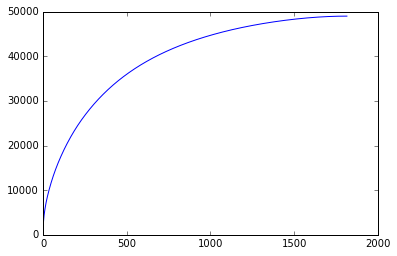

In [56]:
u, s, v = np.linalg.svd(n, full_matrices=False)

plt.plot(np.cumsum(s))

In [57]:
# After plotting, use the first 400 dimensions as the desired.
retained_dimensions = 500
word_vectors = np.dot(u[:, :retained_dimensions], np.diag(s[:retained_dimensions]))
word_vectors = np.absolute(word_vectors)

## 4.2. Word-doc matrix.

The new number of dimensions in the resulting svd matrices must be lower than the number of docs.

So set the number to be 200.

For the word-doc matrix, the right matrix is used.

In [7]:
u, s, v = np.linalg.svd(m, full_matrices=False)

# Use the first 200 dimensions as the desired.
window_vectors = np.dot(np.diag(s), v)
window_vectors = np.absolute(window_vectors)

# 5. Transform word into the new vectors from the SVD results.

This depends on the semantic matrix also.

## 5.1. Cooccurrence matrix.

The result from svd is the representation of word from the "new vectors" in the semantic space. We have to use these "new vectors" together with their appearances in the text to get the text semantic vectors of the "new vectors".

Here, all vectors that represents the text of window are column vectors.

In [46]:
def normalization(v):
    return v / np.sum(v)

In [61]:
window_length = 200
if len(words_stem) % window_length:
    num_windows = len(words_stem) / window_length + 1
else:
    num_windows = len(words_stem) / window_length

window_vectors = np.zeros([retained_dimensions, num_windows])
for ind in range(num_windows):
    tmp_words_numeric = words_stem_numeric[ind*window_length:(ind+1)*window_length]
    goodwords = [w for w in tmp_words_numeric if w in vocab_numeric]
    window_vector = np.zeros([retained_dimensions])
    c = Counter(goodwords)
    for w in c:
        ind_vocab = np.where(vocab_numeric == w)[0][0]
        word_vector = word_vectors[ind_vocab, :]
        window_vector += word_vector * c[w]
    window_vector = normalization(window_vector)
    window_vectors[:, ind] = window_vector


## 5.2. Word-doc matrix.

Comparing with the cooccurrence, word-doc doesn't needed it. But you need only normalization to make the length to 1. This is the requirement when you are using the vectors as the distributions.

In [60]:
def normalization(v):
    return v / np.sum(v)

for ind in range(window_vectors.shape[1]):
    window_vectors[:, ind] = normalization(window_vectors[:, ind])

# 6. Get the Jensen Shannon Divergence for each pair of the new vectors (subtext).

## 6.1. Cooccurrence Matrix.

In [62]:
# Jensen Shannon divergence
def shannon_entropy(dis):
    dis = [-pi * np.log(pi) for pi in dis]
    return sum(dis)

def jensen_shannon_divergence(dis, dis1):
    term = shannon_entropy(0.5 * dis + 0.5 * dis1)
    term1 = 0.5 * shannon_entropy(dis)
    term2 = 0.5 * shannon_entropy(dis1)
    return term - term1 - term2

In [64]:
distances = np.zeros([num_windows, num_windows])
for ind in range(window_vectors.shape[1]-1):
    dis = window_vectors[:, ind]
    
    print 'calculating the %d text' %ind
    
    for ind1 in range(ind+1, window_vectors.shape[1]):
        dis1 = window_vectors[:, ind1]
        distances[ind, ind1] = jensen_shannon_divergence(dis, dis1)

distances = distances + distances.transpose()


calculating the 0 text
calculating the 1 text
calculating the 2 text
calculating the 3 text
calculating the 4 text
calculating the 5 text
calculating the 6 text
calculating the 7 text
calculating the 8 text
calculating the 9 text
calculating the 10 text
calculating the 11 text
calculating the 12 text
calculating the 13 text
calculating the 14 text
calculating the 15 text
calculating the 16 text
calculating the 17 text
calculating the 18 text
calculating the 19 text
calculating the 20 text
calculating the 21 text
calculating the 22 text
calculating the 23 text
calculating the 24 text
calculating the 25 text
calculating the 26 text
calculating the 27 text
calculating the 28 text
calculating the 29 text
calculating the 30 text
calculating the 31 text
calculating the 32 text
calculating the 33 text
calculating the 34 text
calculating the 35 text
calculating the 36 text
calculating the 37 text
calculating the 38 text
calculating the 39 text
calculating the 40 text
calculating the 41 text
ca

## 6.2. Word-doc matrix.

Note that the subtext vectors are the column vectors.

In [9]:
# Jensen Shannon divergence
def shannon_entropy(dis):
    dis = [-pi * np.log(pi) for pi in dis]
    return sum(dis)

def jensen_shannon_divergence(dis, dis1):
    term = shannon_entropy(0.5 * dis + 0.5 * dis1)
    term1 = 0.5 * shannon_entropy(dis)
    term2 = 0.5 * shannon_entropy(dis1)
    return term - term1 - term2

In [10]:
distances = np.zeros([num_windows, num_windows])
for ind in range(window_vectors.shape[1]-1):
    dis = window_vectors[:, ind]
    for ind1 in range(ind+1, window_vectors.shape[1]):
        dis1 = window_vectors[:, ind1]
        distances[ind, ind1] = jensen_shannon_divergence(dis, dis1)
distances = distances + distances.transpose()

# 7. (Cooccurrence matrix) Get path entropy of the real path, and the random for comparison. 

Bernat's basic idea has been used, in the normalized version.

From a network adjacency matrix $M$, which $m_{ij}$ is the Jensen Shannon Divergence between the distribution of the vectors from the SVD results. This edge weight is also the closeness in terms of the semantic distance. So the information entropy (path entropy), which is the information needed given you are on node $i$ and you go to node k (among your first neighbours). 

$I_{ik}=\frac{p_{ik}*\log{p_{ik}}}{\Sigma_{x\subset{su_i}}p_{ix}*\log{p_ix}}$


## 7.1 Get path entropy.

In [65]:
def information(i, j, m):
    # m: a np matrix, i and j: numeric
    row_i = m[i, :]
    pij = row_i[j]
    Iij = - pij * np.log(pij)
    row_i_without_i = row_i[row_i != 0.0]
    Ii = sum(- row_i_without_i * np.log(row_i_without_i))
    return Iij / Ii

In [66]:
path_entropy = .0
for node in range(num_windows-1):
    node1 = node+1
    Iij = information(node, node1, distances)
    path_entropy += Iij

In [67]:
print 'The path entropy of the real path is %f' %path_entropy

The path entropy of the real path is 0.788676


## 7.2 Random paths.

Each point is a subtext. Link weight is the Jensen Shannon Divergence between this two distributions.

In [70]:
# 50 random paths.
infos = []
for count in range(50):
    
    print count
    
    path = range(distances.shape[1])
    random.shuffle(path)
    
    informations = 0.0
    for ind in range(len(path) - 1):
        node = path[ind]
        node1 = path[ind+1]
        Iij = information(node, node1, distances)
        informations += Iij
    infos.append(informations)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


The mean of the random paths results is 0.999094.


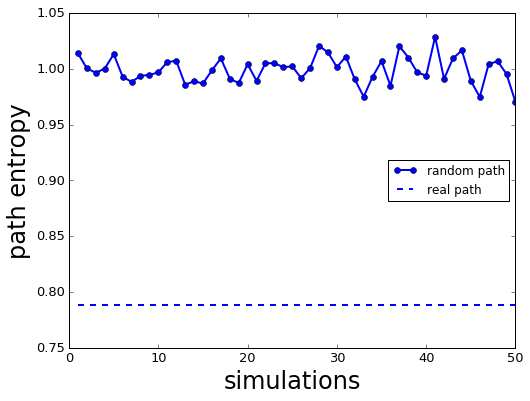

In [71]:
print 'The mean of the random paths results is %f.' %np.mean(infos)

plt.figure(figsize=(8,6))
plt.plot(range(1, 51), infos, marker='o', linewidth=2)
plt.plot(range(1, 51), path_entropy*np.ones(50), 'b--', linewidth=2)
plt.legend(['random path', 'real path'], loc='center right')
plt.ylabel('path entropy', fontsize=24)
plt.xlabel('simulations', fontsize=24)
plt.tick_params(labelsize=13)

The mean of the infos is even smaller than the real path. In the word-doc situation, the path entropy is the strictly smaller than the random path ones, but with a tiny margin. So it means that maybe the random path is not a good null model.

The reason I guess, is that the semantic thread is not always behaving like a stright line. The distance between each two points in the line is not always smallest. The would be some long range relationship that distroies this situation. So I think if I use the random text as a null model, the effect would be larger.

## 7.3 Random text.
Two ways of building the random text:
1. Totally random, appending word from an empty start. The word is choosen by a distribution the same as their time of appearances in the text.
2. Hierachical randomazation from the paper.

### 7.3.1 Totally random text.

In [49]:
_, original_words = ge.read_file('1813 PRIDE AND PREJUDICE.txt', use_zip=0, zf='none')
original_words = original_words[:40000]
random.shuffle(original_words)

stops = stopwords.words('english')
words_0stop = [w for w in original_words if not w in stops]
words_0stop_stem = [porter.stem(w) for w in words_0stop]
c = Counter(words_0stop_stem)
threshold = 4
words_0stop_stem_threshold = [w for w, count in c.items() if count >= threshold]
vocab = words_0stop_stem_threshold
words_stem = [porter.stem(w) for w in original_words]
original_vocab = list(set(words_stem))

# Convert into numbers.
words_stem_numeric = np.array([original_vocab.index(w) for w in words_stem])
vocab_numeric = np.array([original_vocab.index(w) for w in vocab])

def count_cooccurrrence(word, word1, window_length, words_numbers):
    indices_v = np.where(words_numbers == word)
    indices_v1 = np.where(words_numbers == word1)
    distances = np.zeros([np.size(indices_v), np.size(indices_v1)])
    for ind in np.arange(np.size(indices_v)):
        index_v = indices_v[0][ind] # indices_v is tuple
        distances[ind, :] = np.absolute(indices_v1 - index_v)
    threshold = window_length / 2
    return np.sum(distances <= threshold)

def cooccurrence_m(vocab_numbers, words_numbers, window_length):
    m = np.zeros([len(vocab_numbers), len(vocab_numbers)])
    for ind,v in list(enumerate(vocab_numbers))[:-1]:
        
        print 'calculating %d word' %ind
        
        for ind1 in range(ind+1, len(vocab_numbers)):
            v1 = vocab_numbers[ind1]
            m[ind, ind1] = count_cooccurrrence(v, v1, window_length, words_numbers)
    m = m + m.transpose()
    return m


window_length = 200
m = cooccurrence_m(vocab_numeric, words_stem_numeric, window_length)

c = Counter(words_stem_numeric)
r = np.zeros([vocab_numeric.shape[0], vocab_numeric.shape[0]])
for ind, w in list(enumerate(vocab_numeric))[:-1]:
    for ind1 in range(ind+1, len(vocab_numeric)):
        w1 = vocab_numeric[ind1]
        r[ind, ind1] = float(window_length) * c[w] * c[w1] / lenght_original_text
r = r + r.transpose()

n = m - r
n[n < 0] = 0

u, s, v = np.linalg.svd(n, full_matrices=False)

# After plotting, use the first 200 dimensions as the desired.
word_vectors = np.dot(u[:, :200], np.diag(s[:200]))
word_vectors = np.absolute(word_vectors)

def normalization(v):
    return v / np.sum(v)
    
window_length = 200
if len(words_stem) % window_length:
    num_windows = len(words_stem) / window_length + 1
else:
    num_windows = len(words_stem) / window_length

window_vectors = np.zeros([200, num_windows])
for ind in range(num_windows):
    tmp_words_numeric = words_stem_numeric[ind*window_length:(ind+1)*window_length]
    goodwords = [w for w in tmp_words_numeric if w in vocab_numeric]
    window_vector = np.zeros([200])
    c = Counter(goodwords)
    for w in c:
        ind_vocab = np.where(vocab_numeric == w)[0][0]
        word_vector = word_vectors[ind_vocab, :]
        window_vector += word_vector * c[w]
    window_vector = normalization(window_vector)
    window_vectors[:, ind] = window_vector

# Jensen Shannon divergence
def shannon_entropy(dis):
    dis = [-pi * np.log(pi) for pi in dis]
    return sum(dis)

def jensen_shannon_divergence(dis, dis1):
    term = shannon_entropy(0.5 * dis + 0.5 * dis1)
    term1 = 0.5 * shannon_entropy(dis)
    term2 = 0.5 * shannon_entropy(dis1)
    return term - term1 - term2

distances = np.zeros([num_windows, num_windows])
for ind in range(window_vectors.shape[1]-1):
    dis = window_vectors[:, ind]
    
    print 'calculating the %d text' %ind
    
    for ind1 in range(ind+1, window_vectors.shape[1]):
        dis1 = window_vectors[:, ind1]
        distances[ind, ind1] = jensen_shannon_divergence(dis, dis1)

distances = distances + distances.transpose()

def information(i, j, m):
    # m: a np matrix, i and j: numeric
    row_i = m[i, :]
    pij = row_i[j]
    Iij = - pij * np.log(pij)
    row_i_without_i = row_i[row_i != 0.0]
    Ii = sum(- row_i_without_i * np.log(row_i_without_i))
    return Iij / Ii

path_entropy = .0
for node in range(num_windows-1):
    node1 = node+1
    Iij = information(node, node1, distances)
    path_entropy += Iij


calculating 0 word
calculating 1 word
calculating 2 word
calculating 3 word
calculating 4 word
calculating 5 word
calculating 6 word
calculating 7 word
calculating 8 word
calculating 9 word
calculating 10 word
calculating 11 word
calculating 12 word
calculating 13 word
calculating 14 word
calculating 15 word
calculating 16 word
calculating 17 word
calculating 18 word
calculating 19 word
calculating 20 word
calculating 21 word
calculating 22 word
calculating 23 word
calculating 24 word
calculating 25 word
calculating 26 word
calculating 27 word
calculating 28 word
calculating 29 word
calculating 30 word
calculating 31 word
calculating 32 word
calculating 33 word
calculating 34 word
calculating 35 word
calculating 36 word
calculating 37 word
calculating 38 word
calculating 39 word
calculating 40 word
calculating 41 word
calculating 42 word
calculating 43 word
calculating 44 word
calculating 45 word
calculating 46 word
calculating 47 word
calculating 48 word
calculating 49 word
calculatin

In [50]:
print 'path entropy for random text: %f' %path_entropy

path entropy for random text: 1.017205


# 8. (Word-doc matrix) Get path entropy and compare with random paths and random text.

## 8.1. Get path entropy.

In [11]:
def information(i, j, m):
    # m: a np matrix, i and j: numeric
    row_i = m[i, :]
    pij = row_i[j]
    Iij = - pij * np.log(pij)
    row_i_without_i = row_i[row_i != 0.0]
    Ii = sum(- row_i_without_i * np.log(row_i_without_i))
    return Iij / Ii

In [12]:
path_entropy = .0
for node in range(num_windows-1):
    node1 = node+1
    Iij = information(node, node1, distances)
    path_entropy += Iij

In [13]:
print 'The path entropy of the real path is %f' %path_entropy

The path entropy of the real path is 0.987019


## 8.2. Random paths.

In [14]:
# 20 random paths.
infos = []
for count in range(50):
    
    print count
    
    nodes = range(distances.shape[1])
    path = []
    while len(nodes) != 0:
        next_node = random.sample(nodes, 1)[0]
        path.append(next_node)
        nodes.remove(next_node)
    
    informations = 0.0
    for ind in range(len(path) - 1):
        node = path[ind]
        node1 = path[ind+1]
        Iij = information(node, node1, distances)
        informations += Iij
    infos.append(informations)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


The mean of the random paths results is 0.999914.


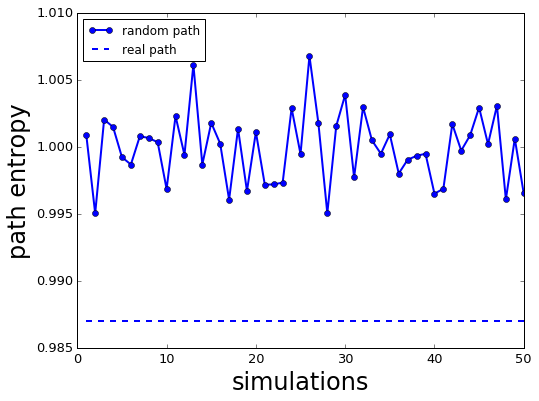

In [17]:
print 'The mean of the random paths results is %f.' %np.mean(infos)

# Plot the result with a base line of the real path.
plt.figure(figsize=(8,6))
plt.plot(range(1, 51), infos, marker='o', linewidth=2)
plt.plot(range(1, 51), path_entropy*np.ones(50), 'b--', linewidth=2)
plt.legend(['random path', 'real path'], loc='upper left')
plt.ylabel('path entropy', fontsize=24)
plt.xlabel('simulations', fontsize=24)
plt.tick_params(labelsize=13)

## 8.3. Random text.

In [47]:
origianl_words = origianl_words[:40000]
random.shuffle(origianl_words)

stops = stopwords.words('english')
words_0stop = [w for w in origianl_words if not w in stops]
words_0stop_stem = [porter.stem(w) for w in words_0stop]
c = Counter(words_0stop_stem)
threshold = 4
words_0stop_stem_threshold = [w for w, count in c.items() if count >= threshold]
final_vocab = words_0stop_stem_threshold
words_stem = [porter.stem(w) for w in origianl_words]

# Get the number of windows and the window length.
window_length = 200
if len(words_stem) % window_length:
    num_windows = len(words_stem) / window_length + 1
else:
    num_windows = len(words_stem) / window_length

# Get the words count in each window.
finalwords_inwindows = []
for ind in range(num_windows):
    window_words = words_stem[ind*window_length:(ind+1)*window_length]
    tmp = [w for w in window_words if w in final_vocab]
    finalwords_inwindows.append(tmp)

# Get the word-doc matrix.
m = np.zeros([len(final_vocab), num_windows])
for ind_window, finalwords_inwindow in enumerate(finalwords_inwindows):
    c = Counter(finalwords_inwindow)
    for word, count in c.items():
        ind_word = final_vocab.index(word)
        m[ind_word, ind_window] = count

u, s, v = np.linalg.svd(m, full_matrices=False)

# Use the first 200 dimensions as the desired.
window_vectors = np.dot(np.diag(s), v)
window_vectors = np.absolute(window_vectors)

def normalization(v):
    return v / np.sum(v)

for ind in range(window_vectors.shape[1]):
    window_vectors[:, ind] = normalization(window_vectors[:, ind])

# Jensen Shannon divergence
def shannon_entropy(dis):
    dis = [-pi * np.log(pi) for pi in dis]
    return sum(dis)

def jensen_shannon_divergence(dis, dis1):
    term = shannon_entropy(0.5 * dis + 0.5 * dis1)
    term1 = 0.5 * shannon_entropy(dis)
    term2 = 0.5 * shannon_entropy(dis1)
    return term - term1 - term2

distances = np.zeros([num_windows, num_windows])
for ind in range(window_vectors.shape[1]-1):
    dis = window_vectors[:, ind]
    for ind1 in range(ind+1, window_vectors.shape[1]):
        dis1 = window_vectors[:, ind1]
        distances[ind, ind1] = jensen_shannon_divergence(dis, dis1)
distances = distances + distances.transpose()

def information(i, j, m):
    # m: a np matrix, i and j: numeric
    row_i = m[i, :]
    pij = row_i[j]
    Iij = - pij * np.log(pij)
    row_i_without_i = row_i[row_i != 0.0]
    Ii = sum(- row_i_without_i * np.log(row_i_without_i))
    return Iij / Ii

r_path_entropy = .0
for node in range(num_windows-1):
    node1 = node+1
    Iij = information(node, node1, distances)
    r_path_entropy += Iij

In [48]:
print 'The random text path entropy is %f' %r_path_entropy

The random text path entropy is 1.000993
